## Project Description

### Objective
You work for the online store Ice, which sells video games all over the world. User and expert reviews, genres, platforms (e.g. Xbox or PlayStation), and historical data on game sales are available from open sources. You need to identify patterns that determine whether a game succeeds or not. This will allow you to spot potential big winners and plan advertising campaigns.

### Outline
- Initialize and preview data
- Data Preprocessing
    - Replace the column names (make them lowercase).
    - Convert the data to the required types.
    - If necessary, decide how to deal with missing values:

    - Calculate the total sales (the sum of sales in all regions) for each game and put these values in a separate column.
- Analyze the data
- Create a user profile for each region
    - For each region (NA, EU, JP), determine:
     - The top five platforms. Describe variations in their market shares from region to region.
     - The top five genres. Explain the difference.
     - Do ESRB ratings affect sales in individual regions?
- Test the following hypotheses:
    - Average user ratings of the Xbox One and PC platforms are the same.
    - Average user ratings for the Action and Sports genres are different.
    - Set the alpha threshold value yourself.
    - Explain:
        — How you formulated the null and alternative hypotheses
        — What significance level you chose to test the hypotheses, and why


### Description of data
Data description
- Name
- Platform
- Year_of_Release
- Genre
- NA_sales (North American sales in USD million)
- EU_sales (sales in Europe in USD million)
- JP_sales (sales in Japan in USD million)
- Other_sales (sales in other countries in USD million)
- Critic_Score (maximum of 100)
- User_Score (maximum of 10)
- Rating (ESRB)
- Data for 2016 may be incomplete.

## Initialize and preview data

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st

df = pd.read_csv('/datasets/games.csv')


In [3]:
# Print general/summary info of dataset
print(df.info())
print()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB
None



,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
# Descriptive statistics of the data
df.describe()


,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


The max values for each colummn indicates that there are outliers (games that sold way more than compared to the majority of games in that region). Distributions should be looked at per region as stdev indicates different spreads and possibly different distributions.



In [5]:
# Number of exact duplicates
df.duplicated().sum()


0

In [6]:
# Missing values
print(df.isna().sum())
df.isna().mean()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64


Name               0.000120
Platform           0.000000
Year_of_Release    0.016093
Genre              0.000120
NA_sales           0.000000
EU_sales           0.000000
JP_sales           0.000000
Other_sales        0.000000
Critic_Score       0.513192
User_Score         0.400897
Rating             0.404786
dtype: float64

The Name, Year of Release, Critic_Score, User_Score, and Rating columns contain null values. The percentage of null values in name and year_of_release are insignificant and will be dropped. The other 3 columns with over 40% null values need to be analyzed further.

## Data preprocessing

In [7]:
# Make every column lowercase
df.columns = df.columns.str.lower()
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


All column names were changed to lower case to avoid future errors.



In [8]:
# Convert data to required types 

# Convert year of release to int
df.year_of_release = df.year_of_release.astype('Int64') #Int64 will do change even with nulls
df.head()


# Convert categorical columns to category
df['genre'] = df['genre'].astype('category')
df['rating'] = df['rating'].astype('category')
df['platform'] = df['platform'].astype('category')

df.info()









<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16715 non-null category
year_of_release    16446 non-null Int64
genre              16713 non-null category
na_sales           16715 non-null float64
eu_sales           16715 non-null float64
jp_sales           16715 non-null float64
other_sales        16715 non-null float64
critic_score       8137 non-null float64
user_score         10014 non-null object
rating             9949 non-null category
dtypes: Int64(1), category(3), float64(5), object(2)
memory usage: 1.1+ MB


User score was incorrectly set as an object but it is numeric. This correction will allow numerical analysis. Year of release was changed to integer as the values are whole numbers. Integers take less memory than floats.

The platform, genre, and rating columns were changed to category as the data does represent categories (a finite list of strings) and saving as categories instead of string/objects helps with memory. We can see that "memory usage" was improved post data type changes

In [9]:
# Calculate sum of all sales for each game and create new column
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


### Name

In [10]:
# Dropping null values in name colummn
df.name.isna().sum()
df = df.dropna(subset=['name']) 
df.name.isna().sum()

0

### Year of Release

In [11]:
# Finding date range of dataset
print(df['year_of_release'].min())
print(df['year_of_release'].max())
df['year_of_release'].nunique()



1980
2016


37

This data shows games released from 1980 to 2016.

In [12]:
# Dropping null values in year_of_release colummn
print(df['year_of_release'].isna().sum() / len(df))
df = df.dropna(subset=['year_of_release']) 


0.016095255190570215


### Genre

In [13]:
# Lowercase
df['genre'] = df['genre'].str.lower()


In [14]:
df['genre'].unique()




array(['sports', 'platform', 'racing', 'role-playing', 'puzzle', 'misc',
       'shooter', 'simulation', 'action', 'fighting', 'adventure',
       'strategy'], dtype=object)

###  Critic Score

In [15]:
# Converting to int datatype
df['critic_score'] = df['critic_score'].astype('Int64') #Int64 will do change even with nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 12 columns):
name               16444 non-null object
platform           16444 non-null category
year_of_release    16444 non-null Int64
genre              16444 non-null object
na_sales           16444 non-null float64
eu_sales           16444 non-null float64
jp_sales           16444 non-null float64
other_sales        16444 non-null float64
critic_score       7983 non-null Int64
user_score         9839 non-null object
rating             9768 non-null category
total_sales        16444 non-null float64
dtypes: Int64(2), category(2), float64(5), object(3)
memory usage: 1.4+ MB


### User Score

There are several rows with 'TBD' or 'to be determined'. One reason for these entries could be that a game is newly released and users have not had a chance to play and review them. When attempting to convert user_score to float we get the error: "ValueError: could not convert string to float: 'tbd'" showed "tbd" used instead of null. Rows with 'tbd' will be replaced by NaN. 



In [16]:
# Replacing 'tbd' entries with Null values
df['user_score'] = np.where(df['user_score'] == 'tbd',None, df['user_score'])

# Convert user_score column to float
df['user_score'] = df['user_score'].astype(float)

df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 12 columns):
name               16444 non-null object
platform           16444 non-null category
year_of_release    16444 non-null Int64
genre              16444 non-null object
na_sales           16444 non-null float64
eu_sales           16444 non-null float64
jp_sales           16444 non-null float64
other_sales        16444 non-null float64
critic_score       7983 non-null Int64
user_score         7463 non-null float64
rating             9768 non-null category
total_sales        16444 non-null float64
dtypes: Int64(2), category(2), float64(6), object(2)
memory usage: 1.4+ MB


### Rating

In [17]:
# Percentage of missing values in rating column
print(df['rating'].unique())
df['rating'].isna().mean()




[E, NaN, M, T, E10+, K-A, AO, EC, RP]
Categories (8, object): [E, M, T, E10+, K-A, AO, EC, RP]


0.40598394551204087

40% of rows in the rating column are missing. Since there are a lot of different ratings, a possible reason for these missing values is that not all of them are used universally.

### Conclusion



User score was incorrectly set as an object but it is numeric and was converted to float. The year of release and critic score columns was changed to integer as the values are whole numbers. Platform, genre, and rating were changed to category as the data does represent categories (a finite list of strings) and saving as categories instead of string/objects helps with memory. 3 columns still have a significant number of nulls (40%) therefore they will not be dropped as it may affect the analysis. The rows with 'tbd' in the user_score column were replaced with None values.

## Analyze the data

In [18]:
#  Number of games released per year
df.groupby('year_of_release')['name'].count()

year_of_release
1980       9
1981      46
1982      36
1983      17
1984      14
1985      14
1986      21
1987      16
1988      15
1989      17
1990      16
1991      41
1992      43
1993      60
1994     121
1995     219
1996     263
1997     289
1998     379
1999     338
2000     350
2001     482
2002     829
2003     775
2004     762
2005     939
2006    1006
2007    1197
2008    1427
2009    1426
2010    1255
2011    1136
2012     653
2013     544
2014     581
2015     606
2016     502
Name: name, dtype: int64

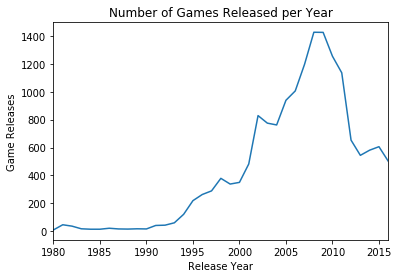

In [19]:
# Plot number of games released per year
df.groupby(['year_of_release'])['name'].count().plot()
plt.title('Number of Games Released per Year')
plt.xlabel("Release Year")
plt.ylabel("Game Releases")
plt.show()


We can see an increase in games released around the time a new generation of console is released. For example in 2005-2006, the PS3 and Xbox 360 were released as successors to the PS2 and Xbox.

Text(0, 0.5, 'Total Sales (mil) USD')

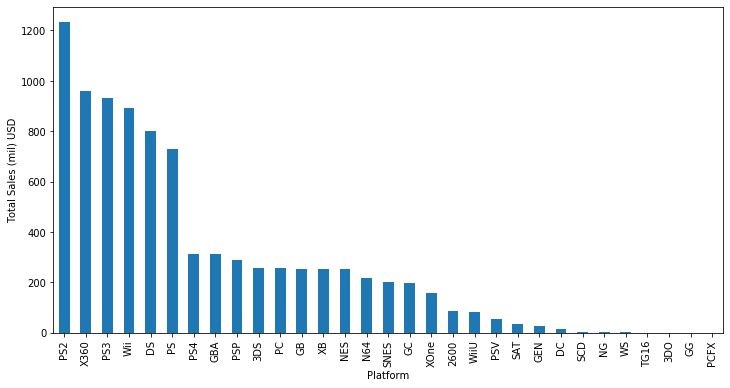

In [20]:
# Plot graph Total sales per platform
plt.figure(figsize=(12,6))
df.groupby('platform')['total_sales'].sum().sort_values(ascending=False).plot(kind='bar')
plt.xlabel('Platform')
plt.ylabel('Total Sales (mil) USD')

In [20]:
# Top 5 platforms
top_platforms = df.groupby(['platform'])['total_sales'].sum().sort_values(ascending=False).head(5).to_frame().reset_index()['platform'].to_list()
top_platforms

['PS2', 'X360', 'PS3', 'Wii', 'DS']

The top 5 most popular platforms in the world are the PS2, Xbox 360, PS3, Wii, and DS.

AxesSubplot(0.125,0.125;0.775x0.755)


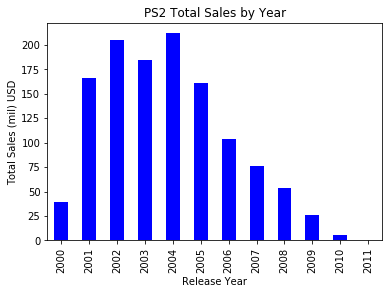

AxesSubplot(0.125,0.125;0.775x0.755)


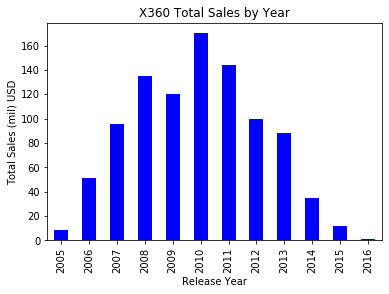

AxesSubplot(0.125,0.125;0.775x0.755)


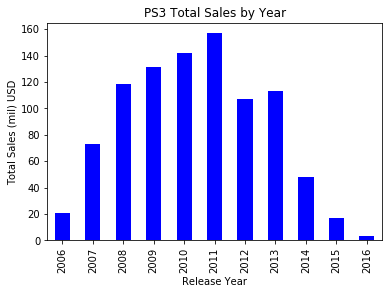

AxesSubplot(0.125,0.125;0.775x0.755)


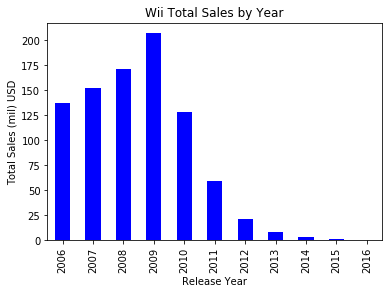

AxesSubplot(0.125,0.125;0.775x0.755)


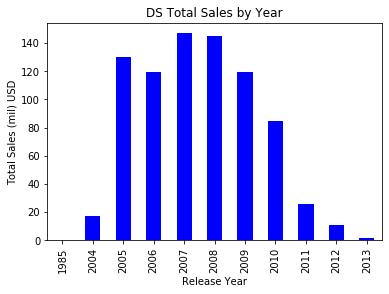

In [21]:
# Plot total sales of top 5 platforms per year
colors = ['red','blue','green','orange','yellow']
for platform in top_platforms:
    chart =  df.loc[df['platform'] == platform]
    print(chart.groupby(['year_of_release'])['total_sales'].sum().plot(kind='bar', color='blue'))
    plt.title(platform +' Total Sales by Year')
    plt.xlabel("Release Year")
    plt.ylabel("Total Sales (mil) USD");
    plt.show()


        
# Not sure how to properly write the loop to make each chart a different color
                                                                                 
                                                                                               
                                                                                               
                                                                                               
                                                                                               
                                                                                               

There seems to be an error in the DS data. The graph shows 1985 as the first year but the DS was first released in 2004. This value will be dropped.

In [22]:
# Dropping 1985 DS data
df.loc[(df['platform']=='DS') & (df['year_of_release']==1985)]
df.drop([15957],inplace=True)


In [23]:
# Average lifespan of top 5 platforms
top_df = df.loc[df['platform'].isin(top_platforms) == True].groupby(['platform'])['year_of_release'].agg({min, max}).reset_index()
top_df['platform_span'] = top_df['max'] - top_df['min']
top_df_span = top_df[['platform','platform_span']].sort_values(by='platform_span', ascending=False).head(5)
top_df_span.platform_span.agg([np.mean,np.median])

mean      10.2
median    10.0
Name: platform_span, dtype: float64

New platforms generally take about 10 years to appear and old ones to fade.

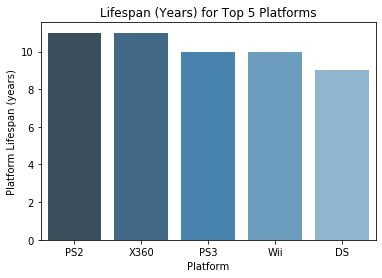

In [24]:
# Plot average lifespan of top 5 platforms
top_df_span['platform'] = top_df['platform'].astype('object')
sns.barplot(x="platform", y="platform_span", data=top_df_span, palette="Blues_d").set_title('Lifespan (Years) for Top 5 Platforms')
plt.xlabel("Platform")
plt.ylabel("Platform Lifespan (years)")
plt.show()


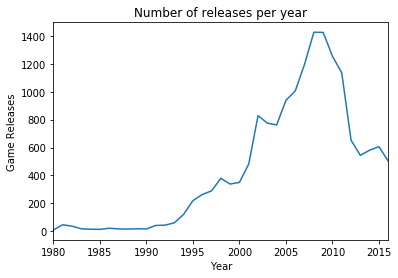

In [25]:
# Number of game releases per year worldwide
df.groupby(['year_of_release'])['platform'].count().plot()
plt.xlabel('Year')
plt.ylabel('Game Releases')
plt.title('Number of releases per year')
plt.show()


In [132]:
# Filter data from 2013
filtered_df = df.query('year_of_release >= 2013')

filtered_df.info()
filtered_df.groupby('platform')['total_sales'].sum().sort_values(ascending=False).head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2233 entries, 16 to 16714
Data columns (total 12 columns):
name               2233 non-null object
platform           2233 non-null category
year_of_release    2233 non-null Int64
genre              2233 non-null object
na_sales           2233 non-null float64
eu_sales           2233 non-null float64
jp_sales           2233 non-null float64
other_sales        2233 non-null float64
critic_score       991 non-null Int64
user_score         1192 non-null float64
rating             1256 non-null category
total_sales        2233 non-null float64
dtypes: Int64(2), category(2), float64(6), object(2)
memory usage: 202.5+ KB


platform
PS4     314.14
PS3     181.43
XOne    159.32
3DS     143.25
X360    136.80
Name: total_sales, dtype: float64

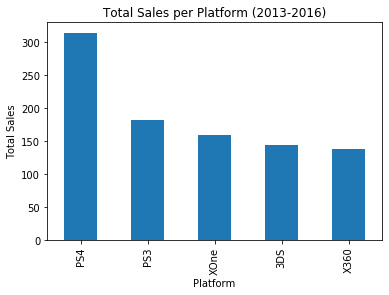

In [133]:
# Plot total sales of top 5 platforms
filtered_df.groupby('platform')['total_sales'].sum().sort_values(ascending=False).head(5).plot(kind='bar')
plt.xlabel('Platform')
plt.ylabel('Total Sales')
plt.title('Total Sales per Platform (2013-2016)')
plt.show()

From 2013-2016, PS4 games outsold it's competitors by a large margine and sold the most units,  followed by the PS3, and then the Xbox One.

In [28]:
# Remove outliers from total sales
top_5_platforms = top_df_span.platform.unique()
top5_platforms_since2013 = filtered_df.query('platform in @top_5_platforms')

Q1 = top5_platforms_since2013['total_sales'].quantile(0.25)
Q3 = top5_platforms_since2013['total_sales'].quantile(0.75)
IQR = Q3 - Q1
print('Q1: ', Q1)
print('Q3: ', Q3)
print('IQR: ', IQR)

bottom_cutoff = Q1 - (1.5*IQR)
top_cutoff = Q3 + 1.5 * IQR
if bottom_cutoff < 0:
    bottom_cutoff = 0
print('min: ',bottom_cutoff)
print('max: ',top_cutoff)

# Remove outliers from data
top5_platforms_since2013 = top5_platforms_since2013.query('total_sales <= @top_cutoff')

Q1:  0.06999999999999999
Q3:  0.49999999999999994
IQR:  0.42999999999999994
min:  0
max:  1.1449999999999998


Outliers may negatively affect our analysis so they are dropped.

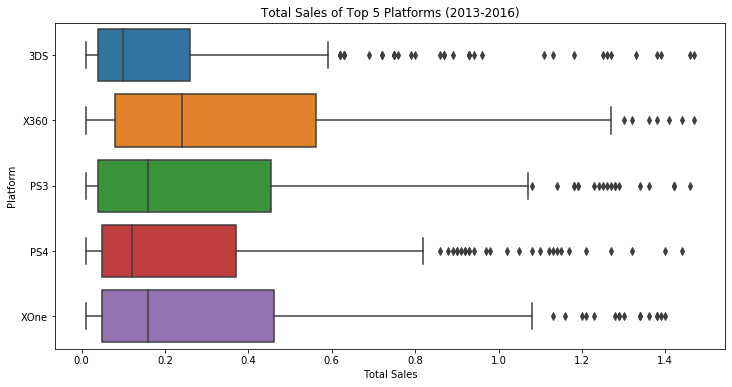

In [136]:
# Build a box plot for the global sales of all games, broken down by top 5 platforms. 
plt.figure(figsize=(12,6))
top5_platforms_since2013['platform'] = top5_platforms_since2013.platform.astype('object')
sns.boxplot(x='total_sales',y='platform',data=top5_platforms_since2013)
plt.xlabel('Total Sales')
plt.ylabel('Platform')
plt.title('Total Sales of Top 5 Platforms (2013-2016)')
plt.show()

/opt/conda/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


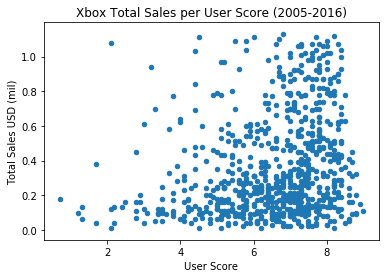

In [30]:
# Replace
top5_platforms_since2013['user_score'] = np.where(top5_platforms_since2013['user_score'] == 'tbd',np.nan, top5_platforms_since2013['user_score'])

# Convert user_score column to float
top5_platforms_since2013['user_score'] = top5_platforms_since2013['user_score'].astype(float)
ps4_data = top5_platforms_since2013.query('platform == "PS4"')

# Plot 
ps4_data.plot(x='user_score',y='total_sales',kind='scatter')
plt.xlabel("User Score")
plt.ylabel("Total Sales USD (mil)")
plt.title('PS4 Total Sales per User Score (2013-2016)')
plt.show()


In [179]:
# calculate the correlation between user reviews and sales.
print('Correlation between user score and total sales:', ps4_data['user_score'].astype('float64').corr(ps4_data['total_sales']).astype('float64')
)

Correlation between user score and total sales: 0.027407856148379758


There is close to no correlation between user score and total sales for PS4 games.

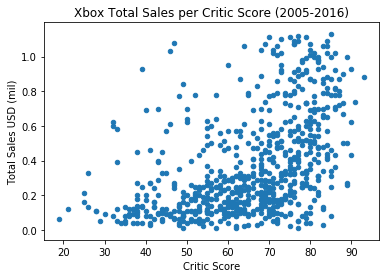

In [32]:
# Total sales vs critic score
PS4_data.plot(x='critic_score',y='total_sales',kind='scatter')
plt.xlabel("Critic Score")
plt.ylabel("Total Sales USD (mil)")
plt.title('PS4 Total Sales per Critic Score (2013-2016)')
plt.show()

In [180]:
# Find correlation between total sales and critic score
print('Correlation between critic score and total sales:', ps4_data['critic_score'].astype('float64').corr(ps4_data['total_sales']).astype('float64')
)


Correlation between critic score and total sales: 0.3105805246902244


There is a moderate correlation between critic score and total score for PS4 games. As critic score improve, total sales moderately improve.

Text(0, 0.5, 'Genre')

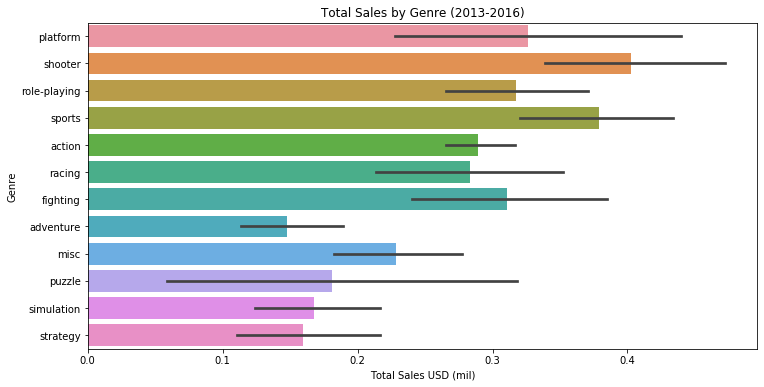

In [236]:
plt.figure(figsize=(12,6))
sns.barplot(x="total_sales", y="genre", data=top5_platforms_since2013).set_title('Total Sales by Genre (2013-2016)')
#top5_platforms_past_decade.genre.unique()
plt.xlabel("Total Sales USD (mil)")
plt.ylabel("Genre")



In [237]:
# Median total sales per genre
pd.DataFrame(top5_platforms_since2013.groupby('genre')['total_sales'].median().sort_values(ascending=False))

,total_sales
genre,
shooter,0.310
sports,0.230
racing,0.170
role-playing,0.160
fighting,0.160
platform,0.150
action,0.140
misc,0.130
simulation,0.120


From 2013-2016, The shooter and sports genres were the most popular across all platforms.

### Conclusion

A majority of games were released from 2000-2010. The top 5 most popular platforms in the world since 1985 are the PS2, Xbox 360, PS3, Wii, and DS. New platforms generally take about 10 years to appear and old ones to fade. From 2013-2016, PS4 games outsold it's competitors by a large margine and sold the most units,  followed by the PS3, and then the Xbox One. Since 2013, the shooter and sports genres were the most popular across all platforms.

## Create user profile for each region

### Japan

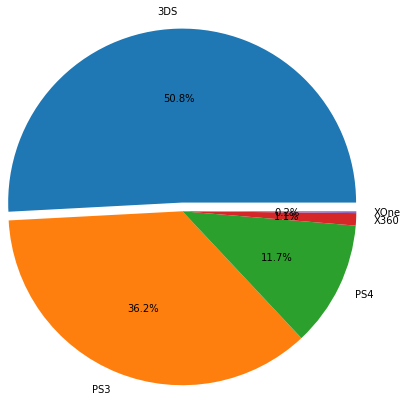

In [253]:
# Create user profile for Japan

japan = top5_platforms_since2013[['name','platform','year_of_release','genre','jp_sales','critic_score','user_score','rating','total_sales']]
japan = japan.query('jp_sales >0')

# Pie chart
labels = ['3DS','PS3','PS4','X360','XOne']
plt.pie(japan.groupby('platform')['jp_sales'].sum().sort_values(ascending=False),labels=labels,autopct='%1.1f%%',radius=2,explode=[0.1,0,0,0,0])

plt.show()

The Nintendo 3DS was by far the most popular platform in Japan from 2013-2016, followed by the PS3 and PS4, respectively.

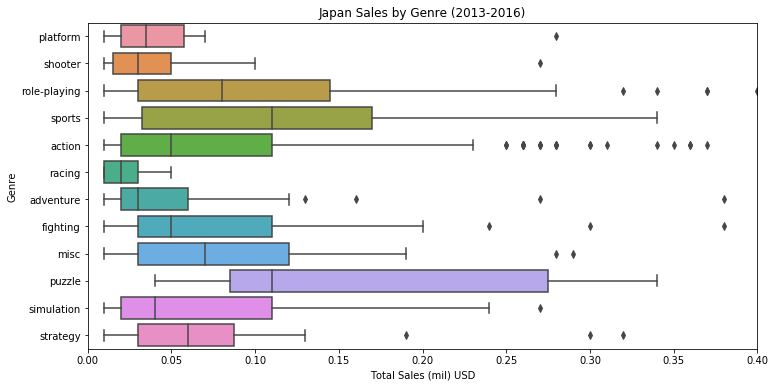

In [228]:
# Genres

plt.figure(figsize=(12,6))
sns.boxplot(x="jp_sales", y="genre", data=japan).set_title('Japan Sales by Genre (2013-2016)')
plt.ylabel('Genre')
plt.xlabel('Total Sales (mil) USD')
plt.xlim(0,0.4)
plt.show()




In [223]:
# Median total sales per genre

pd.DataFrame(japan.groupby('genre')['total_sales'].median().sort_values(ascending=False))


,total_sales
genre,
racing,0.42
shooter,0.41
sports,0.26
platform,0.23
fighting,0.18
role-playing,0.16
action,0.14
simulation,0.12
puzzle,0.11


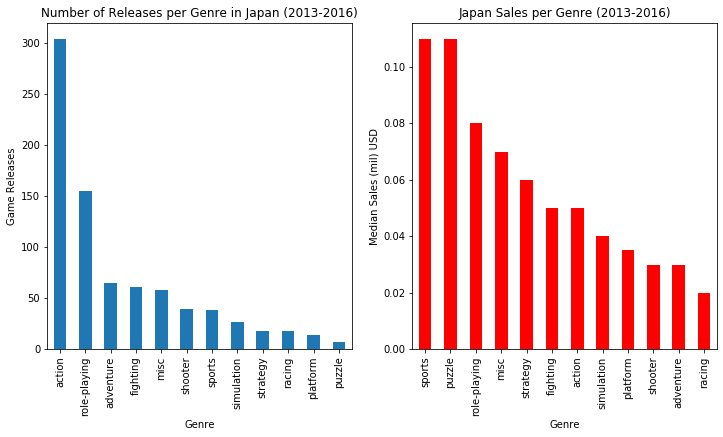

In [227]:
# Plot and compare releases per genre
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6))
japan.genre.value_counts().plot(kind='bar',ax=ax1).set_title('Number of Releases per Genre in Japan (2013-2016)')
japan.groupby('genre')['jp_sales'].median().sort_values(ascending=False).plot(kind='bar',color='red').set_title('Japan Sales per Genre (2013-2016)')

ax1.set_xlabel('Genre')
ax2.set_xlabel('Genre')

ax1.set_ylabel('Game Releases')
ax2.set_ylabel('Median Sales (mil) USD')
plt.show()





Due to the presence of outliers, the median was used instead of the mean to aggregate the data. The action genre had the most game releases in Japan from 2013-2016, but the most popular genres by median total sales were sports and puzzle, followed by role-playing.

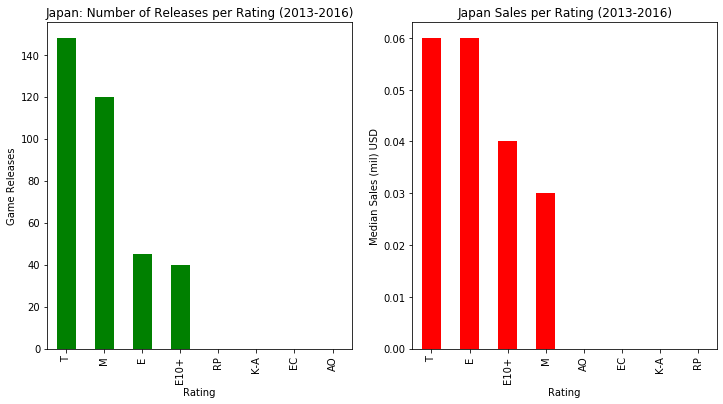

In [226]:
# Rating 
japan['rating'].value_counts(normalize=True)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6))
japan['rating'].value_counts().plot(kind='bar',color='green',ax=ax1).set_title('Japan: Number of Releases per Rating (2013-2016)')
japan.groupby('rating')['jp_sales'].median().sort_values(ascending=False).plot(kind='bar',color='red',ax=ax2).set_title('Japan Sales per Rating (2013-2016)')

ax1.set_xlabel('Rating')
ax2.set_xlabel('Rating')

ax1.set_ylabel('Game Releases')
ax2.set_ylabel('Median Sales (mil) USD')
plt.show()




In [220]:
japan.rating.isna().mean()

0.5609452736318408

#### Summary
The Nintendo 3DS was by far the most popular platform in Japan from 2013-2016, followed by the PS3 and PS4, respectively. The Xbox 360 has the least sales out of the top 5 platforms. The action genre had the most game releases in Japan from 2013-2016, but the most popular genres by median total sales were sports and puzzle, followed by role-playing. The most profitable game rating is T and and E.



### North America

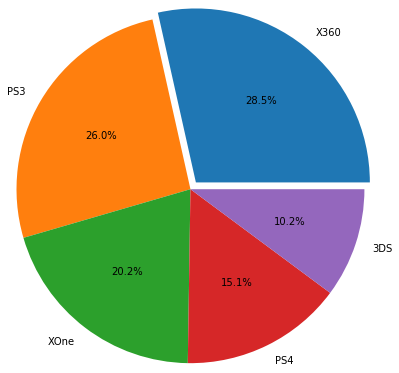

In [252]:
# Create user profile for North America
north_america = top5_platforms_since2013[['name','platform','year_of_release','genre','na_sales','critic_score','user_score','rating','total_sales']]
north_america = north_america.query('na_sales>0')

# Pie chart
labels = ['X360','PS3','XOne','PS4','3DS']
plt.pie(north_america.groupby('platform')['na_sales'].sum().sort_values(ascending=False),labels=labels,autopct='%1.1f%%',radius=2,explode=[0.1,0,0,0,0])


plt.show()



The Xbox 360 was the most popular platform in North America from 2013-2016, closely followed by the PS3 and Xbox One, respectively.

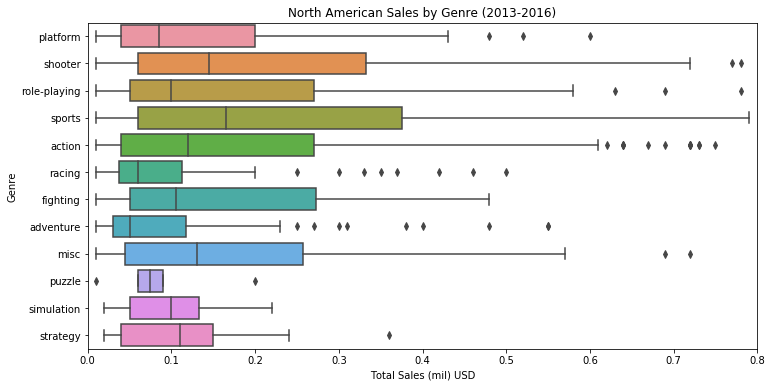

In [233]:
# Genres
plt.figure(figsize=(12,6))
sns.boxplot(x="na_sales", y="genre", data=north_america).set_title('North American Sales by Genre (2013-2016)')
plt.xlabel('Total Sales (mil) USD')
plt.ylabel('Genre')
plt.xlim(0,0.8)
plt.show()

In [209]:
# Median total sales per genre in North America
pd.DataFrame(north_america.groupby('genre')['total_sales'].median().sort_values(ascending=False))


,total_sales
genre,
sports,0.440
shooter,0.340
fighting,0.305
misc,0.270
action,0.270
role-playing,0.260
racing,0.230
strategy,0.220
simulation,0.205


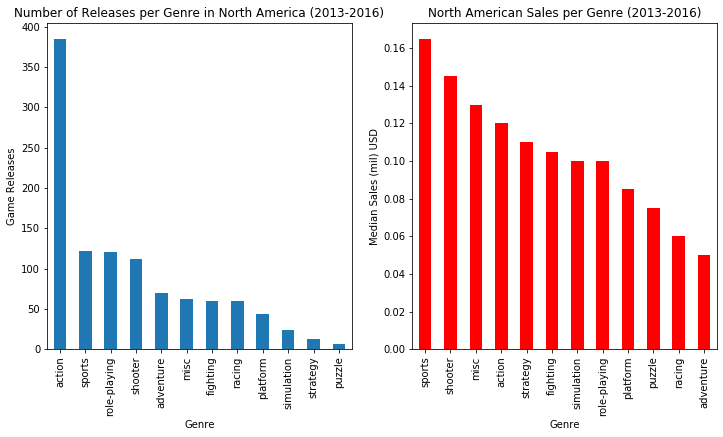

In [224]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6))
north_america.genre.value_counts().plot(kind='bar',ax=ax1).set_title('Number of Releases per Genre in North America (2013-2016)')
north_america.groupby('genre')['na_sales'].median().sort_values(ascending=False).plot(kind='bar',color='red').set_title('North American Sales per Genre (2013-2016)')
ax1.set_xlabel('Genre')
ax2.set_xlabel('Genre')
ax1.set_ylabel('Game Releases')
ax2.set_ylabel('Median Sales (mil) USD')
plt.show()

#north_america.genre.value_counts().plot(kind='bar',color='red')


Due to the presence of outliers, the median was used instead of the mean to aggregate the data. The action genre had the most game releases in North America from 2013-2016, but the most popular genres by total median sales were sports, followed by shooter.

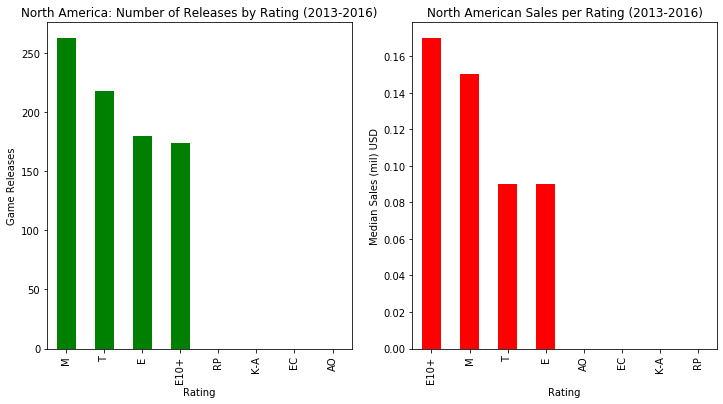

In [225]:
# ratings

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6))
north_america['rating'].value_counts().plot(kind='bar',color='green',ax=ax1).set_title('North America: Number of Releases by Rating (2013-2016)')
north_america.groupby('rating')['na_sales'].median().sort_values(ascending=False).plot(kind='bar',color='red',ax=ax2).set_title('North American Sales per Rating (2013-2016)')

ax1.set_xlabel('Rating')
ax2.set_xlabel('Rating')

ax1.set_ylabel('Game Releases')
ax2.set_ylabel('Median Sales (mil) USD')



plt.show()


#### Summary
The Xbox 360 was the most popular platform in North America from 2013-2016, closely followed by the PS3 and Xbox One, respectively. The Nintendo 3DS was the least popular among the top 5 platforms in North America. The action genre had the most game releases in North America from 2013-2016, but the most popular genres by total median sales were sports, followed by shooter. The most profitable game rating in North America from 2013-2016 was E10+ followed by M.

### Europe

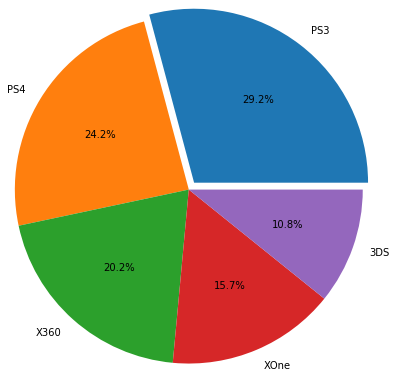

In [254]:
# Create user profile for Europe

europe = top5_platforms_since2013[['name','platform','year_of_release','genre','eu_sales','critic_score','user_score','rating','total_sales']]
europe = europe.query('eu_sales >0')

# Pie Chart
labels = ['PS3','PS4','X360','XOne','3DS']
plt.pie(europe.groupby('platform')['eu_sales'].sum().sort_values(ascending=False),labels=labels,autopct='%1.1f%%',radius=2,explode=[0.1,0,0,0,0])


plt.show()


The most popular platform sold in Europe from 2013-2016 was the PS3, followed by the PS4 and then the Xbox 360.

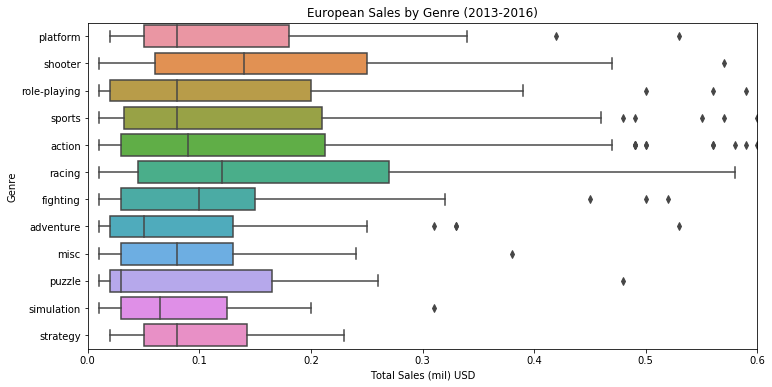

In [234]:
# genres

plt.figure(figsize=(12,6))
sns.boxplot(x="eu_sales", y="genre", data=europe).set_title('European Sales by Genre (2013-2016)')
plt.xlabel('Total Sales (mil) USD')
plt.ylabel('Genre')
plt.xlim(0,0.6)
plt.show()

In [211]:
pd.DataFrame(europe.groupby('genre')['total_sales'].median().sort_values(ascending=False))


,total_sales
genre,
shooter,0.355
sports,0.345
fighting,0.330
misc,0.310
role-playing,0.260
action,0.260
platform,0.250
strategy,0.220
racing,0.220


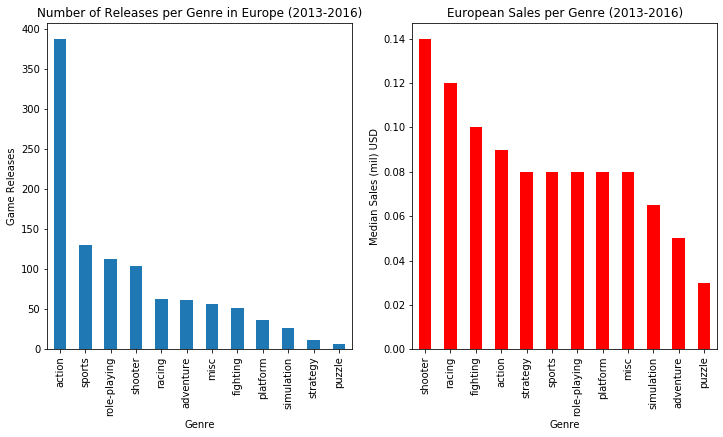

In [231]:
# top genres
europe.genre.value_counts(normalize=True)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6))
europe.genre.value_counts().plot(kind='bar',ax=ax1).set_title('Number of Releases per Genre in Europe (2013-2016)')
europe.groupby('genre')['eu_sales'].median().sort_values(ascending=False).plot(kind='bar',color='red').set_title('European Sales per Genre (2013-2016)')
ax1.set_xlabel('Genre')
ax2.set_xlabel('Genre')
ax1.set_ylabel('Game Releases')
ax2.set_ylabel('Median Sales (mil) USD')
plt.show()

Due to the presence of outliers, the median was used instead of the mean to aggregate the data. The action genre had the most game releases in Europe from 2013-2016, but the most popular genres by sales was shooter, followed by racing and fighting.

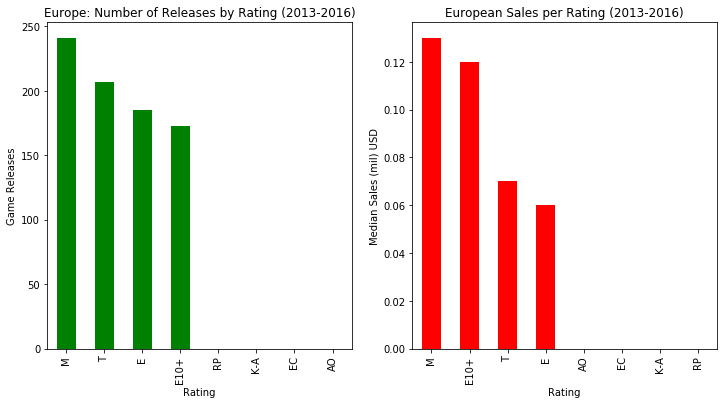

In [232]:
# rating
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6))
europe.rating.value_counts().plot(kind='bar',color='green',ax=ax1).set_title('Europe: Number of Releases by Rating (2013-2016)')
europe.groupby('rating')['eu_sales'].median().sort_values(ascending=False).plot(kind='bar',color='red',ax=ax2).set_title('European Sales per Rating (2013-2016)')

ax1.set_xlabel('Rating')
ax2.set_xlabel('Rating')

ax1.set_ylabel('Game Releases')
ax2.set_ylabel('Median Sales (mil) USD')
plt.show()

#### Summary
The most popular platform sold in Europe from 2013-2016 was the PS3, followed by the PS4 and then the Xbox 360. The Nintendo 3DS was the least popular among the top 5 platforms in sold in Europe. The action genre had the most game releases in Europe from 2013-2016, but the most popular genres by median total sales was shooter, followed by racing and fighting. The most profitable game rating in Europe was M, closely followed by E10+.

## Hypothesis Testing

Average user ratings of the Xbox One and PC platforms are the same.
- Null hypothesis ($H_O$)
    - Average user ratings of the Xbox One and PC platforms are equal.
- Alternate hypothesis ($H_a$)
    - Average user ratings of the Xbox One and PC platforms are not equal.




In [48]:
from scipy import stats as st

alpha= 0.05
xbox_sample = df.query('platform == "XOne"')
xbox_sample.user_score.dropna(inplace=True)

pc_sample = df.query('platform == "PC"')
pc_sample.user_score.dropna(inplace=True)
pc_sample.isna().sum()

results = st.ttest_ind(xbox_sample.user_score, pc_sample.user_score)

print('p-value: ', results.pvalue)
if (results.pvalue < alpha):
        print("We reject the null hypothesis")
else:
        print("We can't reject the null hypothesis")

p-value:  1.3037979620149106e-05
We reject the null hypothesis


/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:4784: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(result)


As the p-value is less than 0.05, there is a significant difference between the user score of Xbox One games and PC games. Therefore, we can reject the hypothesis that the user ratings between XBox One and PC are the same and accept the alternative hypothesis that the average user rating between XBox One and PC games differs.

Average user ratings for the Action and Sports genres are different.
- Null hypothesis ($H_O$)
    - Average user ratings for the Action and Sports genres are equal.
- Alternate hypothesis ($H_a$)
    - Average user ratings for the Action and Sports genres are not equal.


In [49]:
from scipy import stats as st
alpha = 0.05

action_sample = df.query('genre == "action"')
action_sample.user_score.dropna(inplace=True)

pc_sample = df.query('genre == "sports"')
pc_sample.user_score.dropna(inplace=True)

results = st.ttest_ind(action_sample.user_score, pc_sample.user_score)

print('p-value: ', results.pvalue)

if (results.pvalue < alpha):
        print("We reject the null hypothesis")
else:
        print("We can't reject the null hypothesis")

p-value:  0.06480928064420527
We can't reject the null hypothesis


As the p-value is greater than 0.05, there is no significant difference between the average user scores of action games and sports games. Therefore, we cannot reject the hypothesis that the user scores between action and sports games are the same.

## General Conclusion

The objective of this project was to identify patterns that determine whether a game succeeds or not. 

Below are insights discovered:
- The top 5 most popular platforms in the world since 1985 are the PS2, Xbox 360, PS3, Wii, and DS.
- New platforms generally take about 10 years to appear and old ones to fade
- From 2013-2016, PS4 games outsold it's competitors by a large margine and sold the most units,  followed by the PS3, and then the Xbox One.
- There is close to no correlation between user score and total sales for PS4 (most popular platfrom from 2013-2016) games.
- There is a moderate correlation between critic score and total score for PS4 games. As critic score improve, total sales moderately improve.
- From 2013-2016, The shooter and sports genres were the most popular across all platforms.



In Japan (2013-2016):
- The Nintendo 3DS was by far the most popular platform in Japan from 2013-2016, followed by the PS3 and PS4, respectively. 
- The action genre had the most game releases in Japan from 2013-2016, but the most popular genres by median total sales were sports and puzzle, followed by role-playing. 
- The most profitable game rating is T and and E.
   
   
   
   
In North America (2013-2016):
- The Xbox 360 was the most popular platform in North America from 2013-2016, closely followed by the PS3 and Xbox One, respectively.
- The Nintendo 3DS was the least popular among the top 5 platforms in North America. 
- The action genre had the most game releases in North America from 2013-2016, but the most popular genres by total median sales were sports, followed by shooter. 
- The most profitable game rating in North America from 2013-2016 was E10+ followed by M.

In Europe (2013-2016):
- The most popular platform sold in Europe from 2013-2016 was the PS3, followed by the PS4 and then the Xbox 360. 
- The Nintendo 3DS was the least popular among the top 5 platforms in sold in Europe. 
- The action genre had the most game releases in Europe from 2013-2016, but the most popular genres by median total sales was shooter, followed by racing and fighting. 
- The most profitable game rating in Europe was M, closely followed by E10+.

In conclusion, there are several factors that work in tandem that determine whether a game succeeds or not, with the most important being genre, the platform(s) that the game is sold on, and critic scores.
